In [1]:
# Import the necessary components
from epydemix import EpiModel, simulate
from epydemix.visualization import plot_quantiles

# Defining a basic SIR model
sir_model = EpiModel(
    name='SIR Model',
    compartments=['S', 'I', 'R'],  # Susceptible, Infected, Recovered
    parameters={
        'beta': 0.3,  # Transmission rate
        'gamma': 0.1  # Recovery rate
    }
)

# Defining the transitions
sir_model.add_transition(source='S', target='I', rate='beta', agent='I')
sir_model.add_transition(source='I', target='R', rate='gamma')

# Initial conditions
initial_conditions = {
    'S': 100000-10,  
    'I': 10,   
    'R': 0     
}

# running the simulations


In [2]:
def run_sir(dt=1, resample_frequency=None): 
    trajectory = simulate(sir_model,
        start_date="2024-01-01",
        end_date="2024-04-10", dt=dt, resample_frequency=resample_frequency)

    return trajectory  

In [3]:
%timeit run_sir()   

24.9 ms ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array(['2024-01-01T00:00:00.000000000', '2024-01-02T00:00:00.000000000',
       '2024-01-03T00:00:00.000000000', '2024-01-04T00:00:00.000000000',
       '2024-01-05T00:00:00.000000000', '2024-01-06T00:00:00.000000000',
       '2024-01-07T00:00:00.000000000', '2024-01-08T00:00:00.000000000',
       '2024-01-09T00:00:00.000000000', '2024-01-10T00:00:00.000000000',
       '2024-01-11T00:00:00.000000000', '2024-01-12T00:00:00.000000000',
       '2024-01-13T00:00:00.000000000', '2024-01-14T00:00:00.000000000',
       '2024-01-15T00:00:00.000000000', '2024-01-16T00:00:00.000000000',
       '2024-01-17T00:00:00.000000000', '2024-01-18T00:00:00.000000000',
       '2024-01-19T00:00:00.000000000', '2024-01-20T00:00:00.000000000',
       '2024-01-21T00:00:00.000000000', '2024-01-22T00:00:00.000000000',
       '2024-01-23T00:00:00.000000000', '2024-01-24T00:00:00.000000000',
       '2024-01-25T00:00:00.000000000', '2024-01-26T00:00:00.000000000',
       '2024-01-27T00:00:00.000000000', '2024-01-28

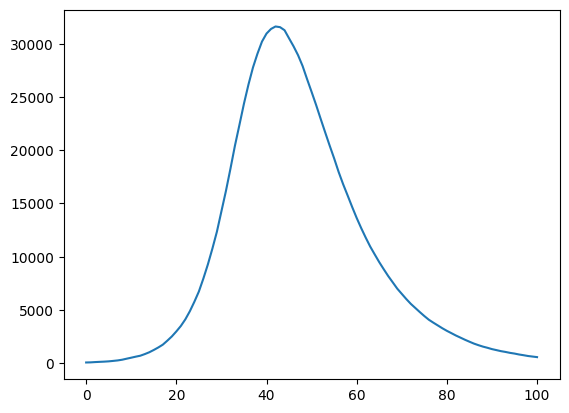

In [7]:
res = run_sir(dt=1, resample_frequency=None)
import matplotlib.pyplot as plt 
plt.plot(res.compartments["I_total"])
res.dates

In [ ]:
import pandas as pd    
from datetime import timedelta
from epydemix.utils import compute_simulation_dates
dt = 1/3
start_date="2024-01-01"
end_date="2024-04-10"
if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
if isinstance(end_date, str):
    end_date = pd.to_datetime(end_date)
total_days = len(pd.date_range(start_date, end_date, freq="D"))
simulation_dates = compute_simulation_dates(start_date, end_date, steps=int(1 / dt) * total_days)
len(simulation_dates)
simulation_dates

In [ ]:
if isinstance(start_date, str):
    start_date = pd.to_datetime(start_date)
if isinstance(end_date, str):
    end_date = pd.to_datetime(end_date)

# Calculate total duration in days
total_days = (end_date - start_date).total_seconds() / (24 * 3600)

# Calculate number of steps if not provided
steps = int(total_days / dt)

# Create timestamps with proper sub-day intervals
timestamps = [
    start_date + pd.Timedelta(days=i * dt)
    for i in range(steps + 1)
]

len(timestamps)
timestamps

In [ ]:
len(pd.date_range(start_date, end_date, freq="D"))

In [ ]:
if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
if isinstance(end_date, str):
    end_date = pd.to_datetime(end_date)
total_days = (end_date - start_date).total_seconds() / (24 * 3600)

steps = int(total_days / dt)
timestamps = [
        start_date + pd.Timedelta(days=i * dt)
        for i in range(steps + 1)
    ]

len(timestamps)

In [ ]:
compute_simulation_dates(start_date, end_date, steps=301)

In [ ]:
plot_quantiles(res, columns=["I_total", "S_total", "R_total"], title='SIR Model Simulation')

In [2]:
trajectory = simulate(sir_model,
        start_date="2024-01-01",
        end_date="2024-04-10")


In [14]:
simulations = sir_model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10")


In [ ]:
simulations.get_quantiles()

In [ ]:
import pandas as pd 
pd.infer_freq(simulations.dates)